# Homework description
1. Implement a modification of U-net
2. Implement U^2-net

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNW76OF/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNW76OF/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [2]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [3]:
image_width = 256
image_height = 256

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0 # normalize to [0, 1] range
  input_mask -= 1 # convert pixels in the segmentation mask from {1, 2, 3} labeling to {0, 1, 2}
  return input_image, input_mask

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (image_width, image_height))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (image_width, image_height))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 2
BUFFER_SIZE = 8
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
train_batches = (
    train_images
    .cache()
    # fills a buffer with BUFFER_SIZE elements, then randomly samples elements from this buffer, replacing the
    # selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the
    # full size of the dataset is required
    .shuffle(BUFFER_SIZE) 
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [9]:
input_all = tf.keras.layers.Input((image_width, image_height, 3))

x = tf.keras.layers.Conv2D(64, (3, 3), activation='selu', padding='same')(input_all)
x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.MaxPool2D(2)(x1)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='selu', padding='same')(x)
x2 = tf.keras.layers.Conv2D(128, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.MaxPool2D(2)(x2)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='selu', padding='same')(x)
x3 = tf.keras.layers.Conv2D(256, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.MaxPool2D(2)(x3)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='selu', padding='same')(x)
x4 = tf.keras.layers.Conv2D(512, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.MaxPool2D(2)(x4)
x = tf.keras.layers.Conv2D(1024, (3, 3), activation='selu', padding='same')(x)
x = tf.keras.layers.Conv2D(1024, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.concatenate([x, x4])
x = tf.keras.layers.Conv2D(512, (3, 3), activation='selu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.concatenate([x, x3])
x = tf.keras.layers.Conv2D(256, (3, 3), activation='selu', padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.concatenate([x, x2])
x = tf.keras.layers.Conv2D(128, (3, 3), activation='selu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='selu', padding='same')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.concatenate([x, x1])
x = tf.keras.layers.Conv2D(64, (3, 3), activation='selu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='selu', padding='same')(x)

number_of_classes = 3
output = tf.keras.layers.Conv2D(number_of_classes, (2, 2), activation='softmax', padding='same')(x)

model = tf.keras.Model(input_all, output)
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

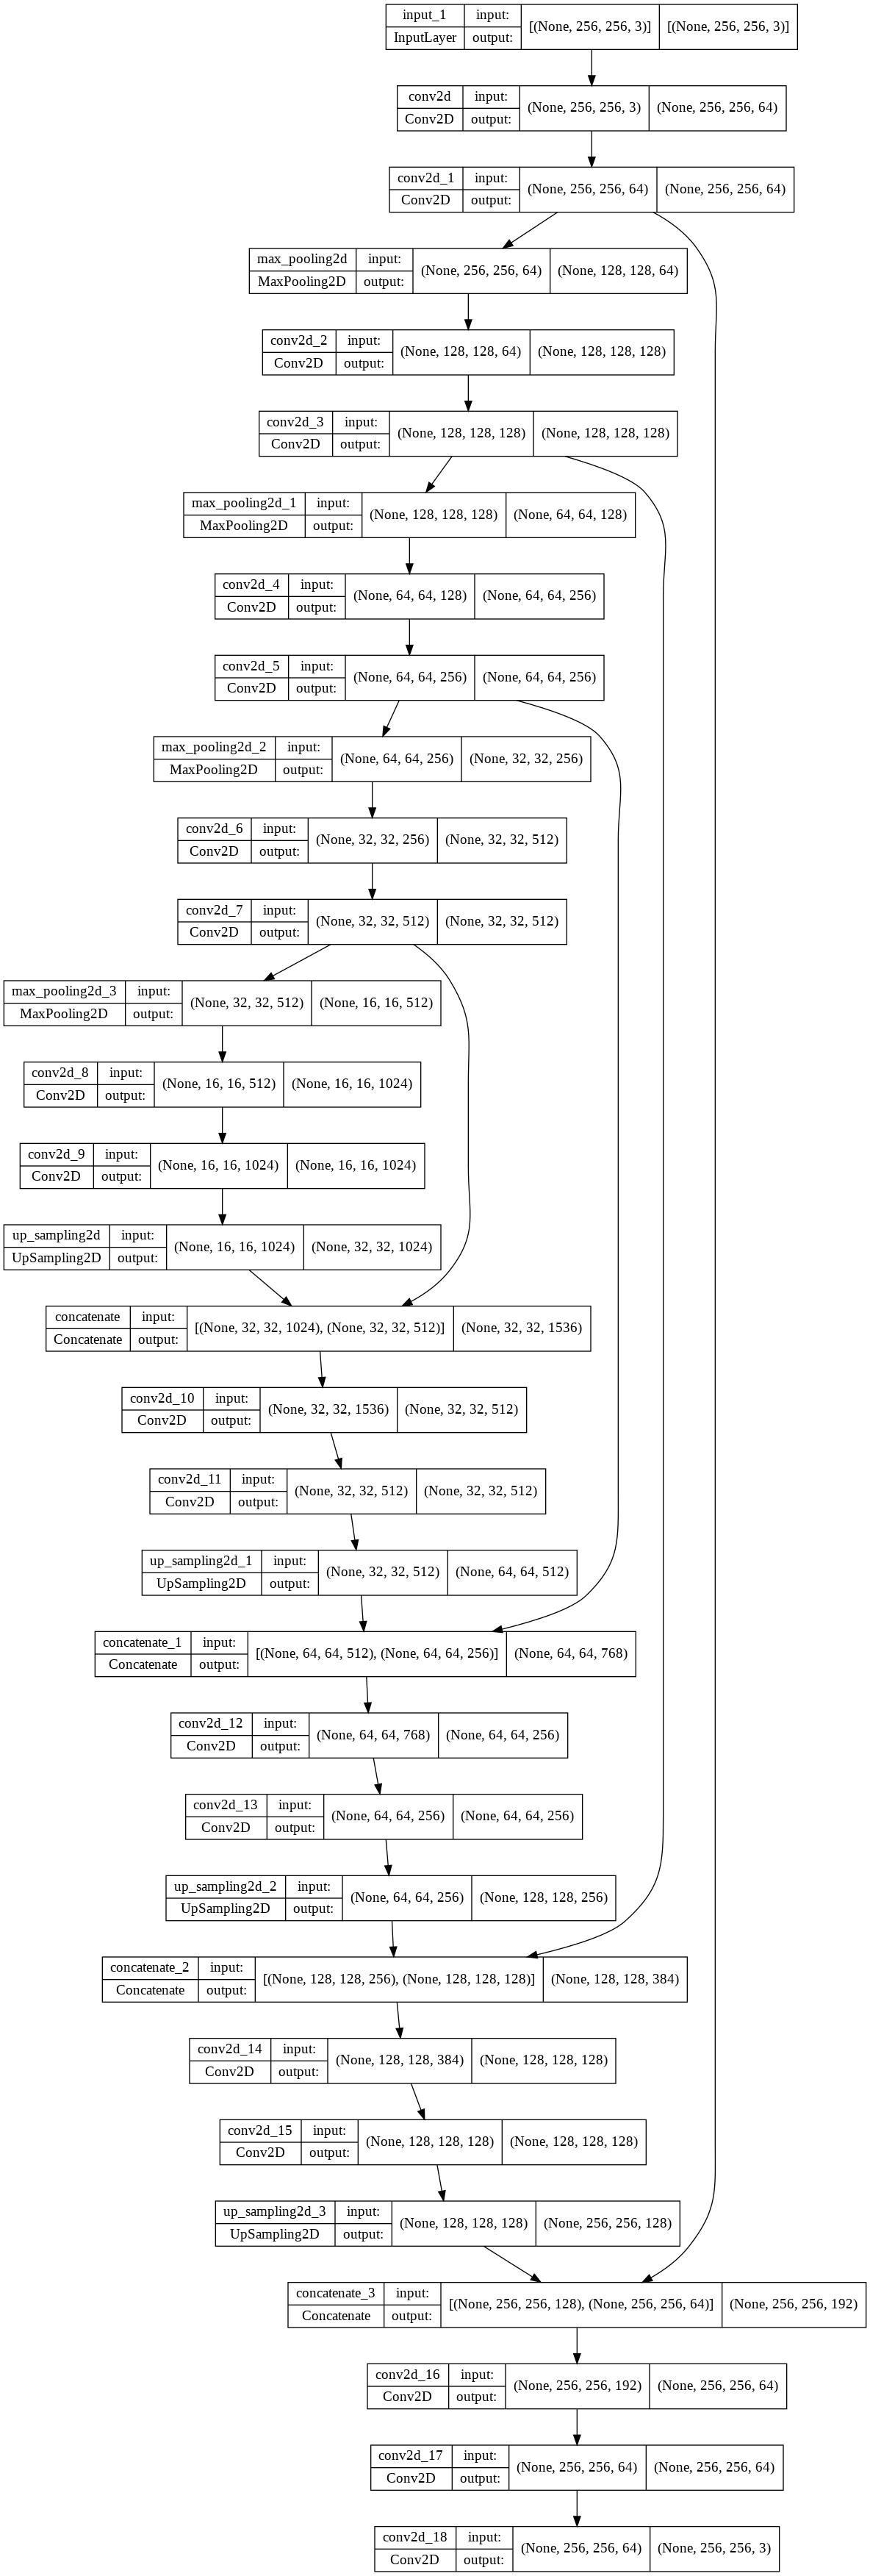

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
EPOCHS = 10

# trained on Google Colab's GPU

model_history = model.fit(train_batches,
          epochs=EPOCHS,
          verbose=1,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=test_batches)

Epoch 1/10
1840/1840 [==============================] - 404s 211ms/step - loss: 0.7416 - accuracy: 0.6716 - val_loss: 0.6142 - val_accuracy: 0.7403
Epoch 2/10
1840/1840 [==============================] - 434s 236ms/step - loss: 0.5697 - accuracy: 0.7609 - val_loss: 0.5197 - val_accuracy: 0.7839
Epoch 3/10
1840/1840 [==============================] - 390s 212ms/step - loss: 0.4859 - accuracy: 0.7986 - val_loss: 0.4487 - val_accuracy: 0.8176
Epoch 4/10
1840/1840 [==============================] - 389s 212ms/step - loss: 0.4404 - accuracy: 0.8176 - val_loss: 0.4243 - val_accuracy: 0.8256
Epoch 5/10
1840/1840 [==============================] - 389s 211ms/step - loss: 0.4093 - accuracy: 0.8309 - val_loss: 0.4049 - val_accuracy: 0.8353
Epoch 6/10
1840/1840 [==============================] - 389s 211ms/step - loss: 0.3824 - accuracy: 0.8421 - val_loss: 0.3958 - val_accuracy: 0.8396
Epoch 7/10
1840/1840 [==============================] - 389s 211ms/step - loss: 0.3578 - accuracy: 0.8517 - val_

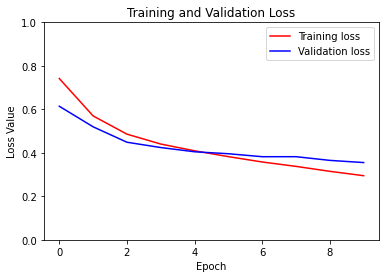

In [18]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [21]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]

In [16]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

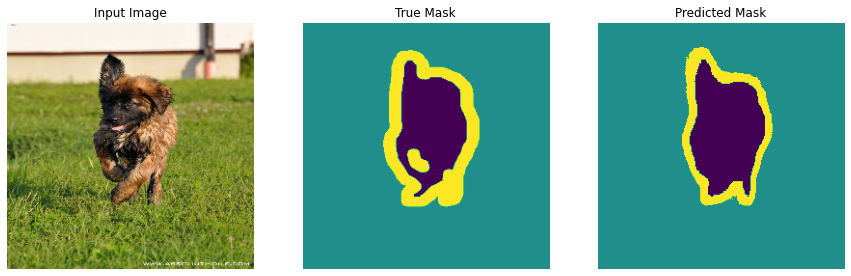

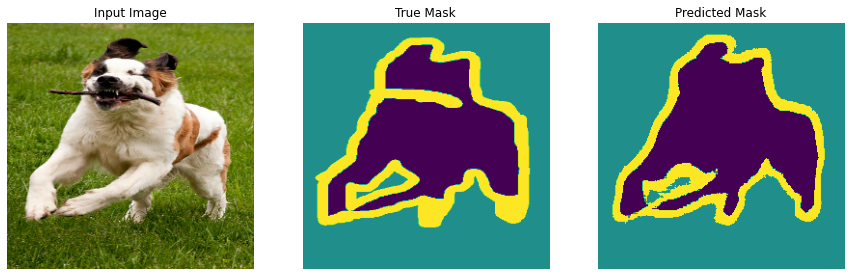

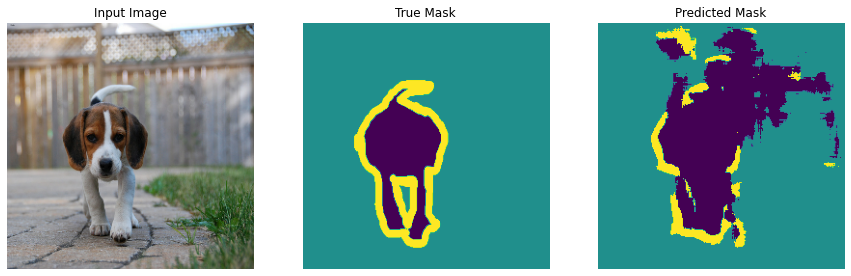

In [17]:
show_predictions(test_batches, 3)